### New Analysis In-Progress

To try to find better results in regards to causes and effects, we are analyzing the past year before the war to try and determine whether we have considerate changes in the period of interest.

#### Imports and Variables

In [2]:
import pandas as pd
import dask.dataframe as dd 
import seaborn as sns

First, I'll just write a script to convert the dataset I've obtained into a new lighter version. This is just part of the data cleaning process.

In [8]:
MONTH_NAME = 'july'
YEAR = '21'
DATASET_ID = '1'
DATASET_NAME = MONTH_NAME+YEAR+'_'+DATASET_ID+'.csv'
df = dd.read_csv(DATASET_NAME)
df = df[['hash', 'block_number','block_timestamp','from_address','to_address','value']]
df

,hash,block_number,block_timestamp,from_address,to_address,value
npartitions=178,,,,,,
,object,int64,int64,object,object,object
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [ ]:
df.to_csv('./light-'+DATASET_NAME, single_file = True)

### Important accounts Analysis

In our previous work (OLIVEIRA, P. H. F.; REZENDE, D. M.; BERNARDINO, H. S.; VILLELA, S. M.; VIEIRA, A. B.; GONC ̧ ALVES, G. D. Análise do comportamento de contas no ethereum durante um evento de impacto na economia. In: SBC. Anais do V Workshop em Blockchain: Teoria, Tecnologias e Aplicações. [S.l.], 2022. p. 54–67.) we found some relevant accounts in the important period of the Russian invasion, with big degree variations. Can these accounts reveal something about that period?

First, let's check X2Y2: X2Y2 Token. The account with most significant change between February 10th and February 17th.

In [34]:
def get_degree_in_month_2021(address, month):
    initial_path = '/home/pedro/Desktop/datasets ethereum - muita coisa/'
    temp_df_0 = dd.read_csv(initial_path+'light-'+month+'21_0.csv', dtype = {'value':'object'})
    temp_df_1 = dd.read_csv(initial_path+'light-'+month+'21_1.csv', dtype = {'value':'object'})
    df = dd.concat([temp_df_0, temp_df_1])
    sent_tx = (df['from_address'] == address)
    received_tx = (df['to_address'] == address)
    df = df[sent_tx | received_tx]
    return len(df.compute())

def get_degree_in_2022(address):
    initial_path = '/home/pedro/Desktop/datasets ethereum - muita coisa/'
    temp_df_0 = dd.read_csv(initial_path+'/fix_war_txs.csv', dtype = {'value':'object'})
    temp_df_1 = dd.read_csv(initial_path+'/fix_war_txs_2.csv', dtype = {'value':'object'})
    temp_df_2 = dd.read_csv(initial_path+'fix_war_txs_3.csv', dtype = {'value':'object'})
    temp_df_3 = dd.read_csv(initial_path+'fix_war_txs_4.csv', dtype = {'value':'object'})
    df = dd.concat([temp_df_0, temp_df_1, temp_df_2, temp_df_3]).rename(columns = {'from': 'from_address', 'to': 'to_address'})
    sent_tx = (df['from_address'] == address)
    received_tx = (df['to_address'] == address)
    df = df[sent_tx | received_tx]
    return len(df.compute())

In [17]:
X2Y2_ADDRESS = '0xfe44daeb65166846fccb3f4aa7186e36247b1c1e'

month_list = ['april', 'may', 'june', 'july', 'august', 'september', 'october', 'november']
X2Y2_dictionary = {'april': 3845, 'may': 3382, 'june' : 5138, 'july': 2645, 'august': 3726, 'september': 2981} 

for month in month_list:
    print('Reading '+month+'...')
    X2Y2_dictionary[month] = get_degree_in_month_2021(X2Y2_ADDRESS, month)


print(X2Y2_dictionary)


Reading april...


KeyboardInterrupt: 

We also need to compare data from the paper we published previously.

In [ ]:
X2Y2_dictionary['10th February to 10th March'] = get_degree_in_2022(X2Y2_ADDRESS)
print(X2Y2_dictionary)

In [44]:
x2y2_df = pd.DataFrame.from_dict(X2Y2_dictionary, orient = 'index', columns =  ['Degree'])
x2y2_df = x2y2_df.reset_index(names = 'Month')
x2y2_df['Account'] = 'X2Y2 Token'
x2y2_df

,Month,Degree,Account
0,april,3845,X2Y2 Token
1,may,3382,X2Y2 Token
2,june,5138,X2Y2 Token
3,july,2645,X2Y2 Token
4,august,3726,X2Y2 Token
5,september,2981,X2Y2 Token
6,october,3670,X2Y2 Token
7,november,3236,X2Y2 Token


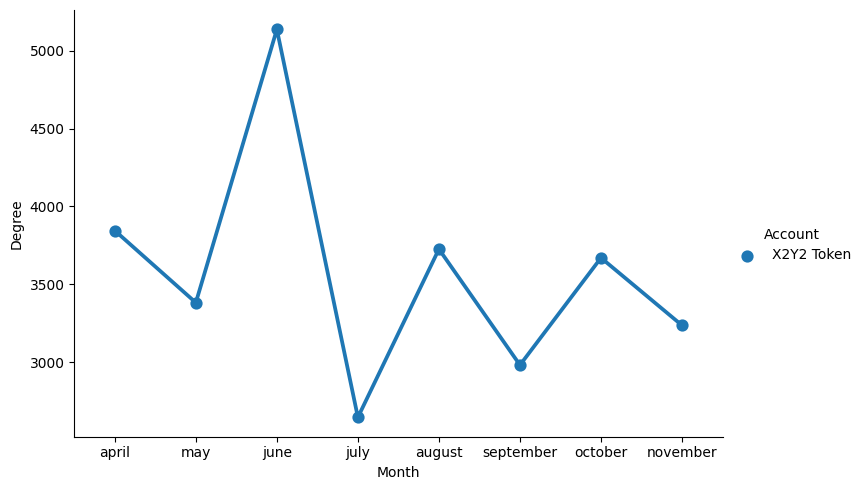

In [48]:
sns.catplot(data = x2y2_df, x = 'Month', y = 'Degree', hue = 'Account', kind = 'point', height=5, aspect=1.5)


That looks good, but it only works for a single address. Also, the script demands all the datasets loaded at once, which is not easy with storage issues. The next couple of cells will try do adjust for these cases.

In [37]:
top_addresses = {
    'hash': [
        '0xA090e606E30bD747d4E6245a1517EbE430F0057e',
        '0x7f268357A8c2552623316e2562D90e642bB538E5',
        '0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8',
        '0x58b6A8A3302369DAEc383334672404Ee733aB239',
        '0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45'
    ],
    'tags': ['Coinbase: Miscellaneous', 'OpenSea: Wyvern Exchange v2', 'Ethermine', 'Livepeer: LPT Token', 'Uniswap V3: Router 2']
}

top_addresses['hash'] = [h.lower() for h in top_addresses['hash']] #the datasets are lowercase, so this is just to make it default
top_addresses_degree = {'Month': [], 'Degree': [], 'Tag': []}

In [13]:
MONTH_NAME = 'march' #For now, I'm changing this constant to change the behavior of the cell to obtain all results

for i in range(len(top_addresses['hash'])):
    top_addresses_degree['Degree'].append(get_degree_in_month_2021(top_addresses['hash'][i], MONTH_NAME))
    top_addresses_degree['Month'].append(MONTH_NAME)
    top_addresses_degree['Tag'].append(top_addresses['tags'][i])

top_addresses_degree

{'Month': ['march', 'march', 'march', 'march', 'march'],
 'Degree': [0, 0, 0, 0, 0],
 'Tag': ['Coinbase: Miscellaneous',
  'OpenSea: Wyvern Exchange v2',
  'Ethermine',
  'Livepeer: LPT Token',
  'Uniswap V3: Router 2']}

Let's also create another cell to fill with information about 2022 data from the start of the russia invasion.

In [38]:
for i in range(len(top_addresses['hash'])):
    top_addresses_degree['Degree'].append(get_degree_in_2022(top_addresses['hash'][i]))
    top_addresses_degree['Month'].append('10th February to 10th March')
    top_addresses_degree['Tag'].append(top_addresses['tags'][i])

top_addresses_degree

{'Month': ['10th February to 10th March',
  '10th February to 10th March',
  '10th February to 10th March',
  '10th February to 10th March',
  '10th February to 10th March'],
 'Degree': [1210208, 1576427, 730995, 100918, 1094593],
 'Tag': ['Coinbase: Miscellaneous',
  'OpenSea: Wyvern Exchange v2',
  'Ethermine',
  'Livepeer: LPT Token',
  'Uniswap V3: Router 2']}

In [39]:

for MONTH_NAME in ['march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november']:

    for i in range(len(top_addresses['hash'])):
        top_addresses_degree['Degree'].append(get_degree_in_month_2021(top_addresses['hash'][i], MONTH_NAME))
        top_addresses_degree['Month'].append(MONTH_NAME)
        top_addresses_degree['Tag'].append(top_addresses['tags'][i])

top_addresses_degree

{'Month': ['10th February to 10th March',
  '10th February to 10th March',
  '10th February to 10th March',
  '10th February to 10th March',
  '10th February to 10th March',
  'march',
  'march',
  'march',
  'march',
  'march',
  'april',
  'april',
  'april',
  'april',
  'april',
  'may',
  'may',
  'may',
  'may',
  'may',
  'june',
  'june',
  'june',
  'june',
  'june',
  'july',
  'july',
  'july',
  'july',
  'july',
  'august',
  'august',
  'august',
  'august',
  'august',
  'september',
  'september',
  'september',
  'september',
  'september',
  'october',
  'october',
  'october',
  'october',
  'october',
  'november',
  'november',
  'november',
  'november',
  'november'],
 'Degree': [1210208,
  1576427,
  730995,
  100918,
  1094593,
  1304570,
  0,
  945642,
  12286,
  0,
  1295727,
  0,
  1009460,
  18933,
  0,
  1649110,
  0,
  1222166,
  17249,
  0,
  1610929,
  0,
  727879,
  15730,
  0,
  1970927,
  0,
  734516,
  11629,
  0,
  1150536,
  0,
  547683,
  6964,
 

In [42]:
df_accs = pd.DataFrame(top_addresses_degree)

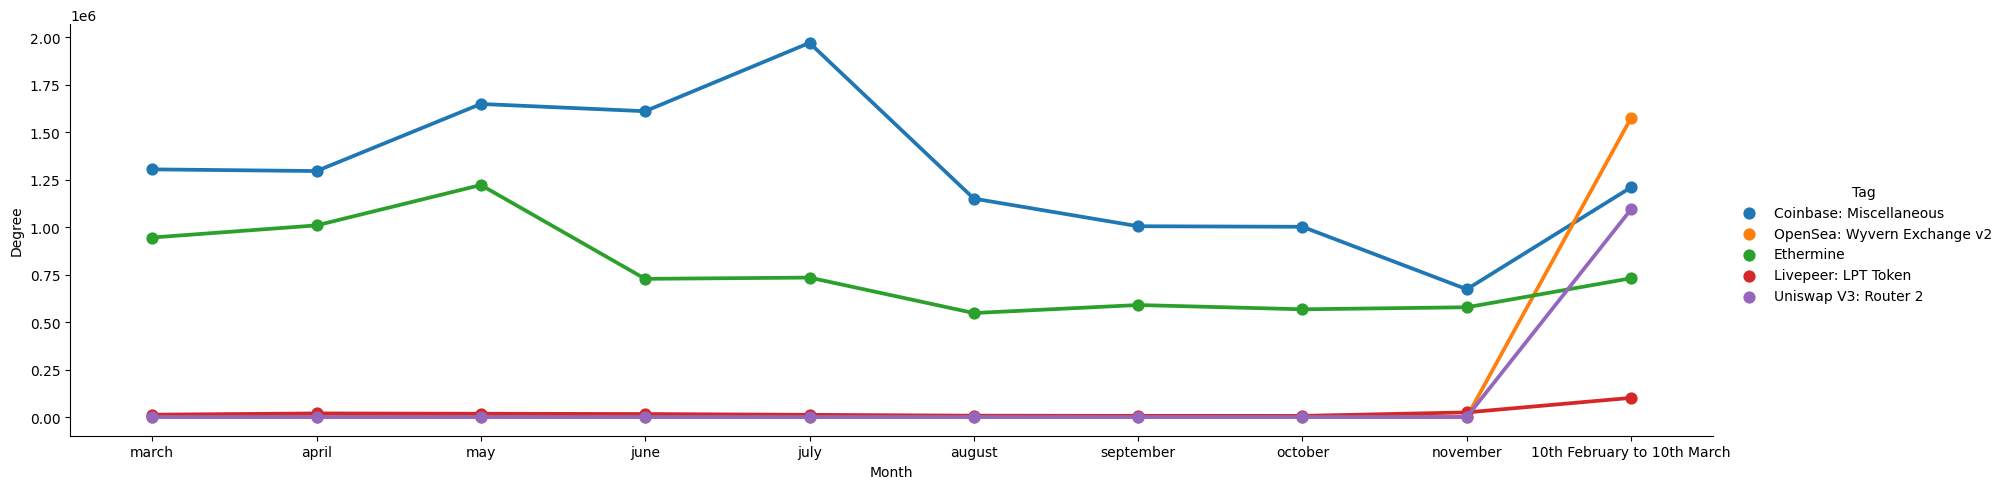

In [47]:
sns.catplot(data = df_accs_2, x = 'Month', y = 'Degree', hue = 'Tag', kind = 'point', height=5, aspect=3.5)

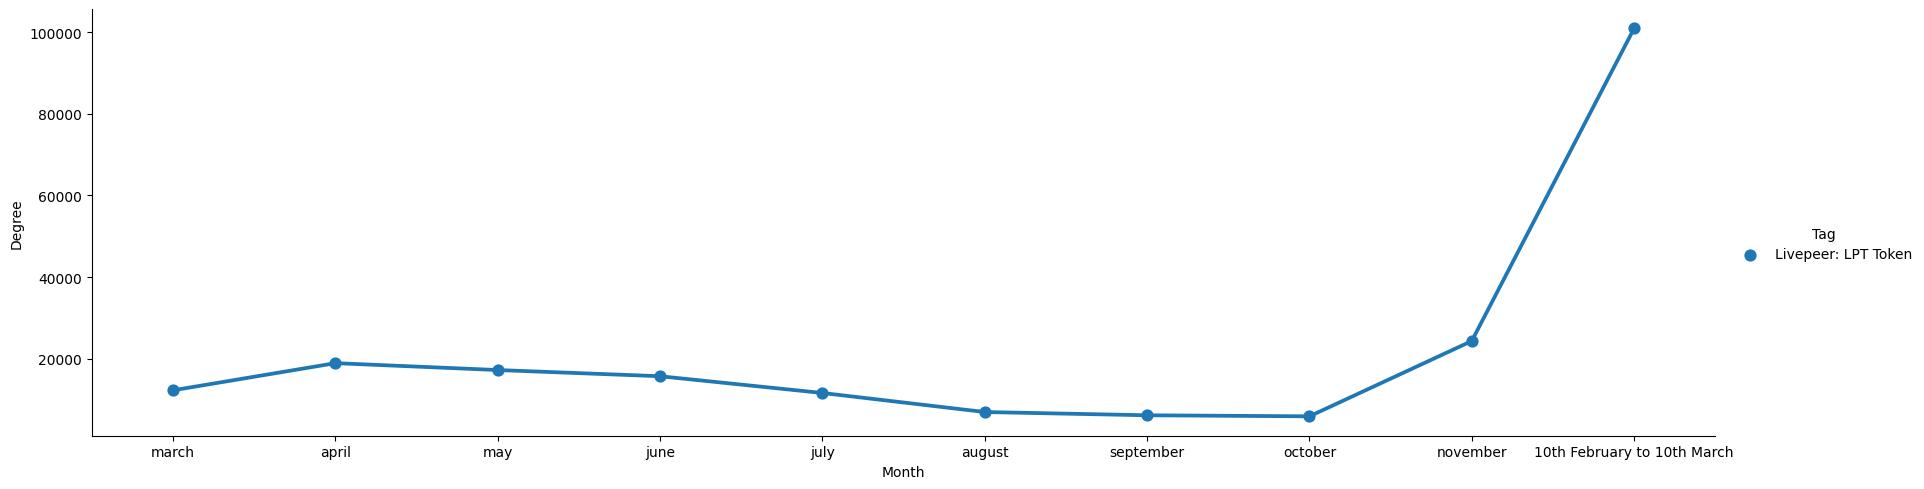

In [48]:
sns.catplot(data = df_accs_2.query('Tag == "Livepeer: LPT Token"'), x = 'Month', y = 'Degree', hue = 'Tag', kind = 'point', height=5, aspect=3.5)

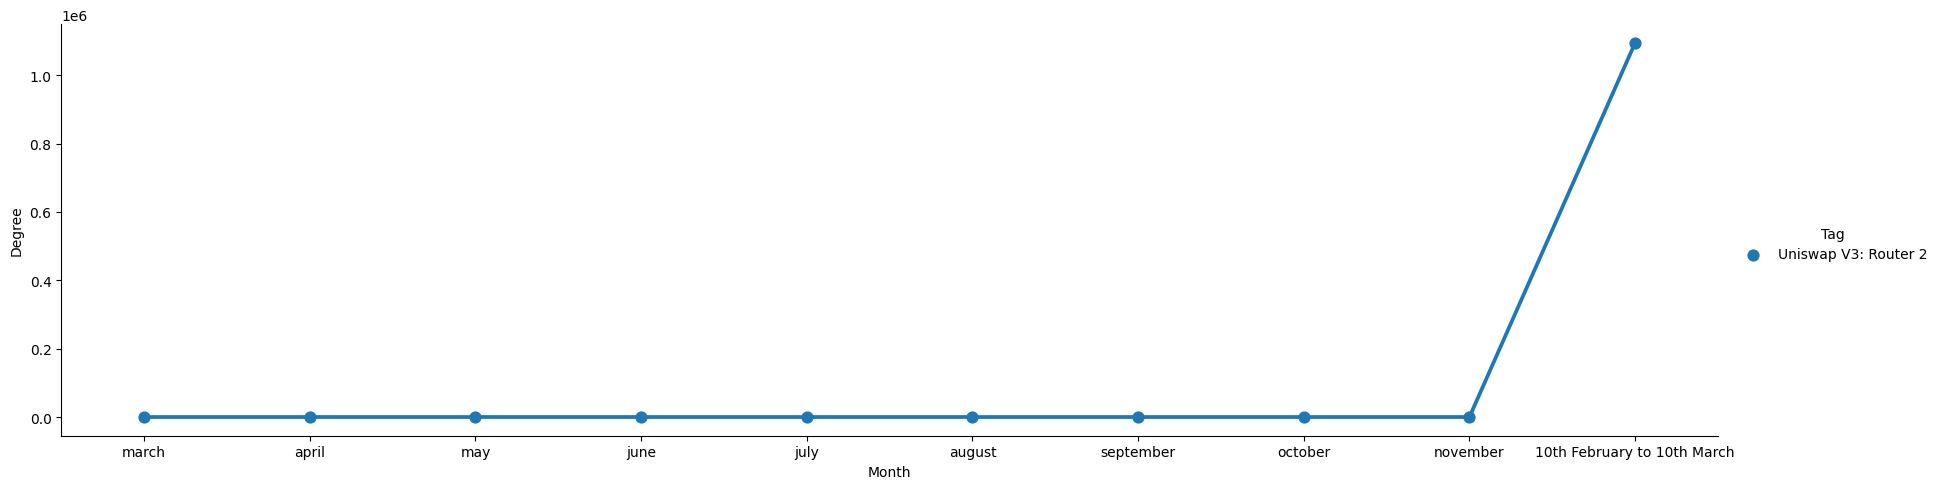

In [49]:
sns.catplot(data = df_accs_2.query('Tag == "Uniswap V3: Router 2"'), x = 'Month', y = 'Degree', hue = 'Tag', kind = 'point', height=5, aspect=3.5)

In [45]:
df_accs_2 = pd.concat([df_accs.iloc[5:], df_accs[:5]])
df_accs_2

,Month,Degree,Tag
5,march,1304570,Coinbase: Miscellaneous
6,march,0,OpenSea: Wyvern Exchange v2
7,march,945642,Ethermine
8,march,12286,Livepeer: LPT Token
9,march,0,Uniswap V3: Router 2
10,april,1295727,Coinbase: Miscellaneous
11,april,0,OpenSea: Wyvern Exchange v2
12,april,1009460,Ethermine
13,april,18933,Livepeer: LPT Token
14,april,0,Uniswap V3: Router 2
